# This is the experiment for clustering with different prompts and without an specified object for the base tasks

In [1]:
import sys
from pathlib import Path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))

from PIL import Image
import sys
from pathlib import Path
from PIL import Image
import torch
import numpy as np
from molmo_utils import load_model, do_inference, get_coordinates, calculate_probability_of_coordinates
from utils import extract_all, plot_scatter, calculate_normalized_euclidian_distance, visualize_points_on_image, calculate_spread, calculate_all_clusters, show_all_clusters

2025-03-02 12:18:00.992441: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-02 12:18:01.507108: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-02 12:18:01.507148: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-02 12:18:01.507181: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-02 12:18:01.564729: I tensorflow/core/platform/cpu_feature_g

In [2]:
model_name = 'allenai/Molmo-7B-D-0924'
model, processor = load_model(model_name)

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
def run_experiment_different_prompts(path_to_experiments, prompt_starts, runs_per_task, temperature, epsilon, min_samples):
    tasks, images, ground_truths, objects = extract_all(path_to_experiments)
    prompt_end = " Your output format should be like this: (x1, y1) with (x1, y1) beeing the coordinates of the relevant object. Dont output anything else."
    softmax_fn = torch.nn.Softmax(dim=-1)
    labels = []

    coordinates = [[],[]]

    distances = [[],[]]
    
    spreads = [[],[]]

    diameters = [[],[]]

    majority_size_rates = [[],[]]


    #probs = [[],[]]
    
    for i in range(len(tasks)):
        prompts = []
        task = tasks[i]
        labels.append(task)
        ground_truth = ground_truths[i]

        objects_of_task = objects[i]
        prompts_what = []
        for prompt_start in prompt_starts:
            prompt = prompt_start + task + "For that you have to point to the object in the picture that has to be moved." + prompt_end
            prompts_what.append(prompt)

        prompts.append(prompts_what)


        print(f"{task}")
        with Image.open(images[i]) as image:
            image_width = image.width
            image_height = image.height
    
            if (len(ground_truth) == 2):
                prompts_where = []
                for prompt_start in prompt_starts:
                    prompt = prompt_start + task + "For that you have to point to the place in the picture where the object has to be moved to." +  prompt_end
                    prompts_where.append(prompt)
                labels.append(task)
                prompts.append(prompts_where)
    
            for k in range(len(prompts)):
                task_coordinates = []
                task_distances = []
                #probabilities = []

                for prompt in prompts[k]:
                    for j in range(runs_per_task):
                        output_text, output, inputs = do_inference(image, prompt, model, processor, temperature)                    
                        coords = get_coordinates(output_text, image_width, image_height)
                        if(coords[0] < 0 or coords[0] < 0):
                            continue
                        
                        norm_dist = calculate_normalized_euclidian_distance(coords, ground_truth[k], image_width, image_height)
                        task_coordinates.append(coords)
                        task_distances.append(norm_dist)
                        #probabilities.append(calculate_probability_of_coordinates(output, inputs, processor))
                    coordinates[k].append(task_coordinates)
                            
                n_clusters, index_majority_cluster, cluster_points, noisy_points, centroids, diameters_of_clusters = calculate_all_clusters(task_coordinates, epsilon=epsilon, min_samples=min_samples)
                if (n_clusters != 0):
                    norm_dist = calculate_normalized_euclidian_distance(centroids[index_majority_cluster], ground_truth[k], image_width, image_height)
                    distances[k].append(norm_dist)
                    spreads[k].append(calculate_spread(task_coordinates, image_width, image_height))
                    diameters[k].append(diameters_of_clusters[index_majority_cluster])
                    majority_size_rates[k].append(len(cluster_points[index_majority_cluster]) / len(task_coordinates))
                    #probs[k].append(np.mean(probabilities))
                    show_all_clusters(image, index_majority_cluster, cluster_points, noisy_points, centroids, diameters_of_clusters)
                else:
                    visualize_points_on_image(image, ["predictions"], [task_coordinates], "")
                    

                print("")

    return coordinates, distances, spreads, diameters, majority_size_rates#, probs


pull the oven tray


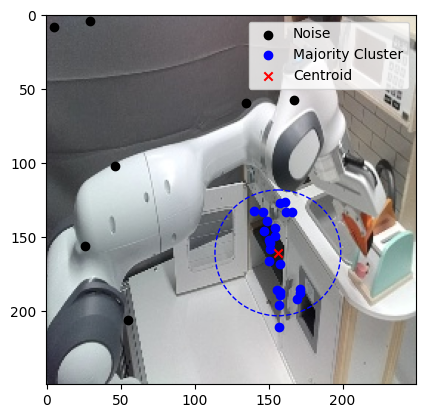


move the fruit from the left stove to the sink


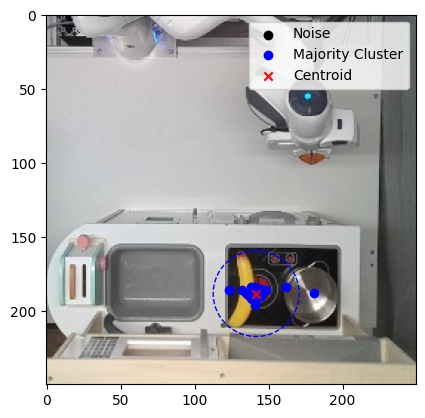

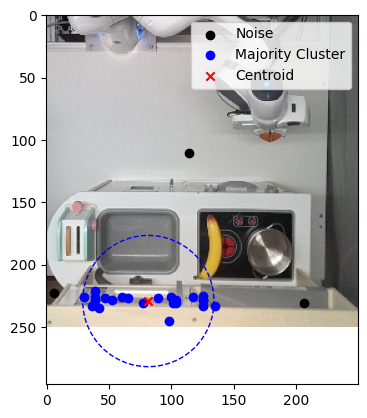


open low fridge


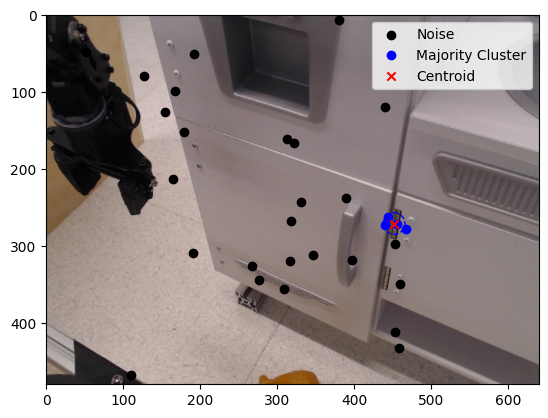


open the drawer


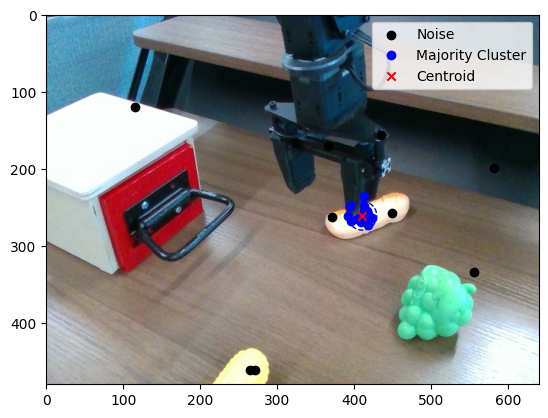


Move the can from the top left of the burner to the bottom left of the burner


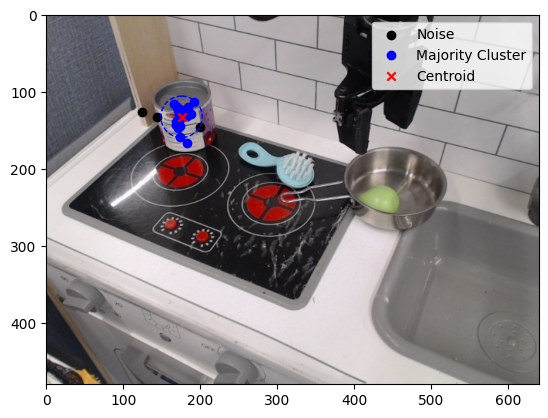

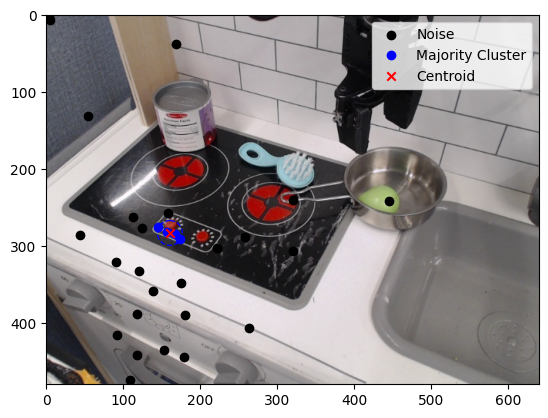


Place the pot to the right of the blue fork.


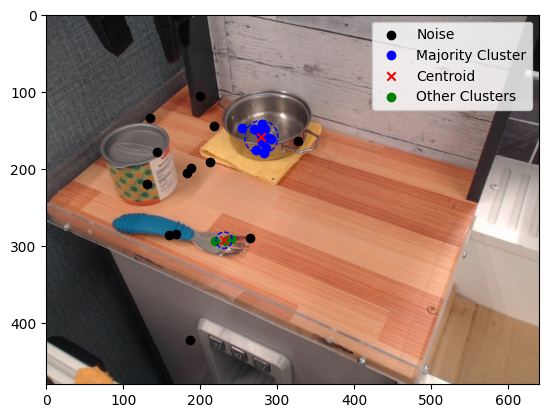

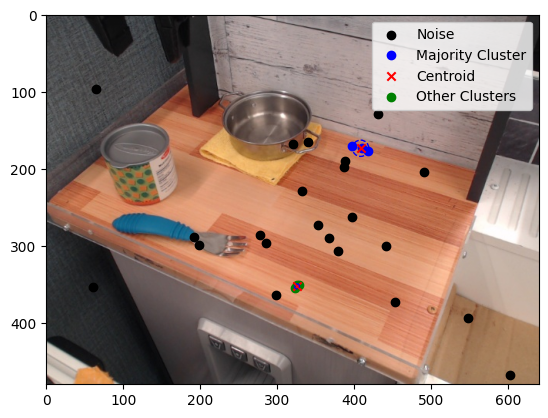


move the pot from the right to the left stove


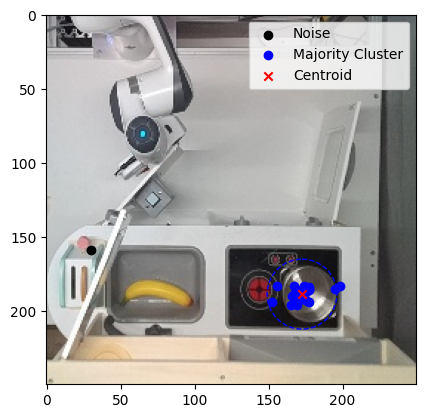

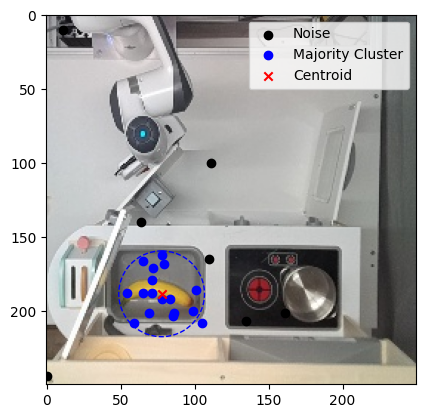


put potato in pot or pan


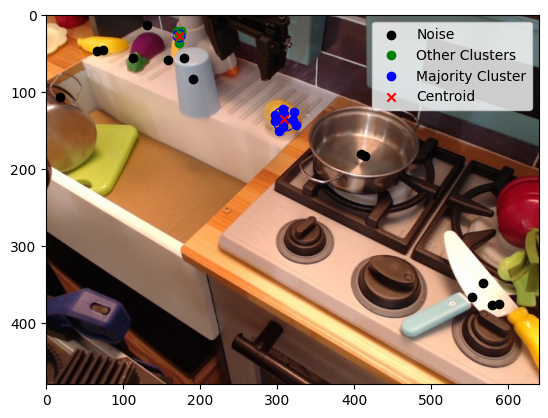

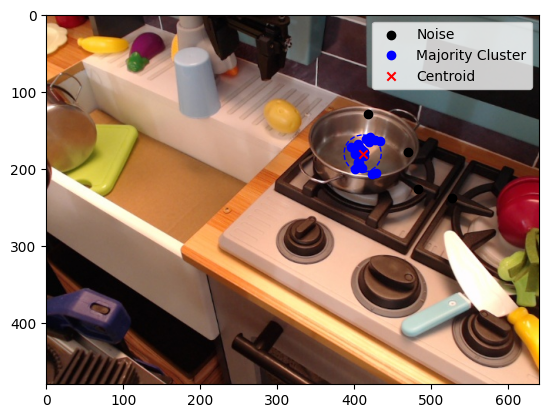


take cucumber out of cup


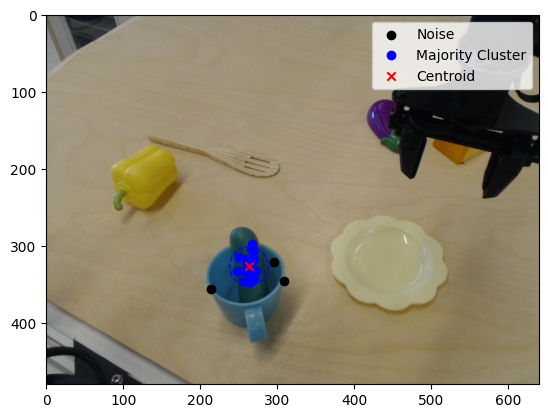


move the banana from the left stove to the sink


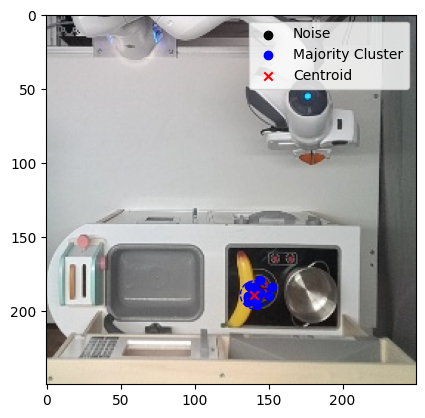

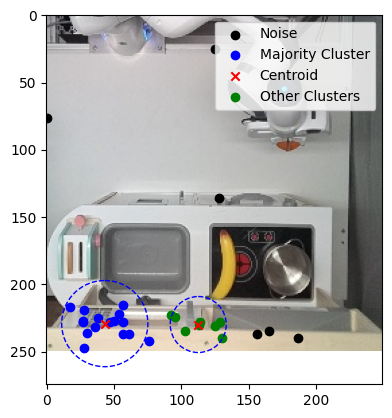


pick up the toast and put it to the sink


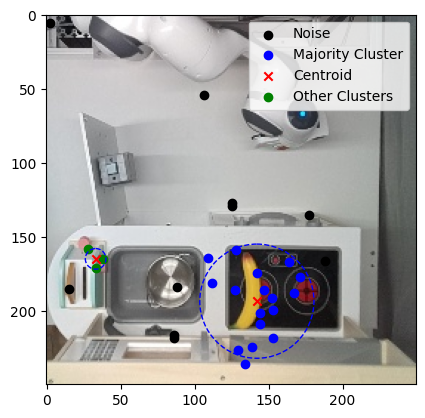

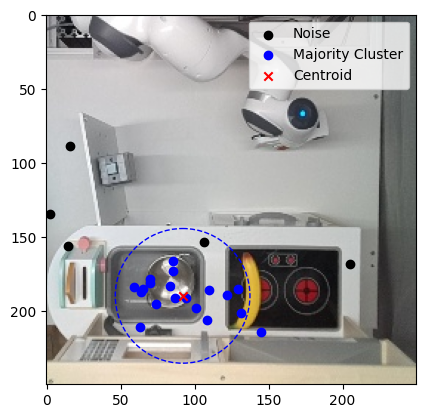


close the microwave


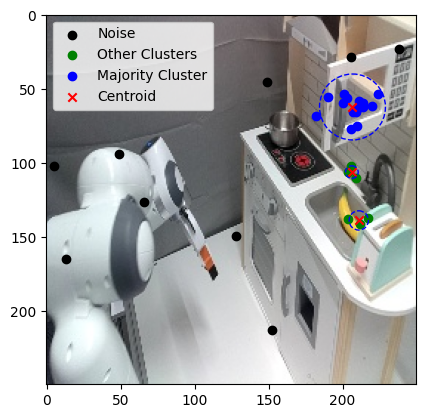


push the toaster lever


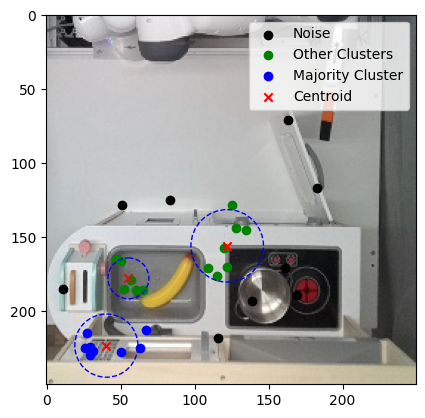


pick up glass cup


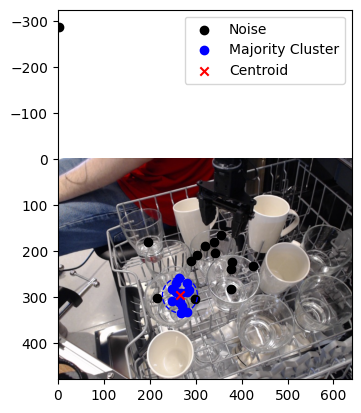


take the broccoli and put it between the two right burners


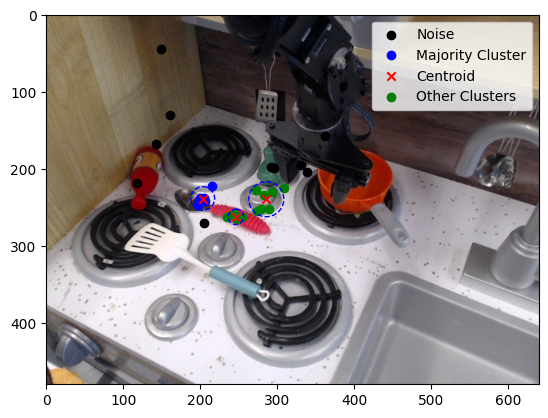

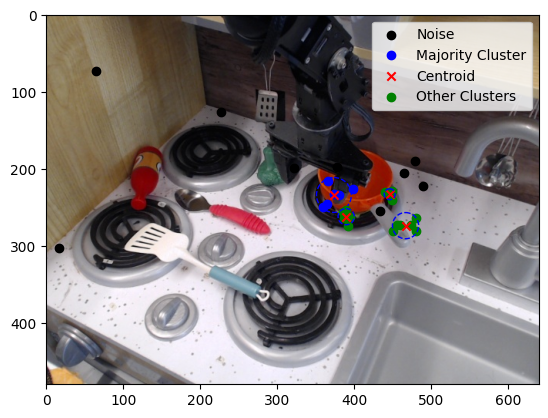


move the pot from the left to the right stove


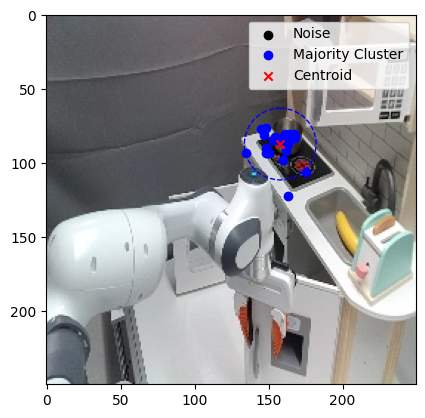

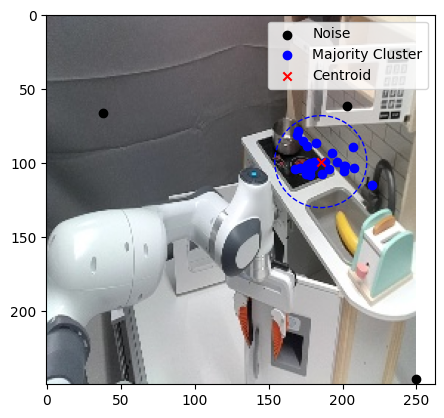

In [4]:
experiment_path = "../data/base_experiments"
num_runs = 6
temperature = 1

epsilon = 20
min_samples = 3

prompt_starts = [
    "You are the robot in the picture. Your mission it to guide and support the user in its task to: ",
    "Your mission it to guide and support the user in its task to: ",
    "You are the robot in the picture. You have to: ",
    "You are the robot. Your mission is to: ",
    "You are the robot in the picture. Your task is to: "
    ]

#prompt_starts = ["You are the robot in the picture. Your mission it to guide and support the user in its task to: ", "You are the robot in the picture. Your mission it to guide and support the user in its task to: "]
#prompt_ends = [, "  Your output format should be like this: (x1, y1) with (x1, y1) beeing the coordinates of the place where the object has to be moved to. Dont output anything else."]

coordinates, distances, spreads, diameters, majority_size_rates = run_experiment_different_prompts(experiment_path, prompt_starts, num_runs, temperature, epsilon, min_samples)